In [1]:
import os
from pathlib import Path

while Path.cwd().name.lower() != "aiml25-exam" and "aiml25-exam" in str(Path.cwd()).lower():
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/isimisi/Documents/GitHub/isimisi/AIML25-Exam


In [2]:
from src.yolo.yolo import Yolo
from ultralytics import YOLO
from src.utils.path import from_root
from src.llm_caller import LLMCaller
from src.llm_detector import Detector
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

In [3]:
model = YOLO(from_root("models/yolo-trained.pt"))

yolo = Yolo(model)

In [4]:
from decouple import config

WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

model = LLMCaller(
    api_key=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    api_url=WX_API_URL,
    model_id="watsonx/meta-llama/llama-3-2-90b-vision-instruct",  
    params={}
)

In [5]:
detector = Detector(model, yolo)

In [6]:
detector.initiate_image(str(from_root("datasets/test/images/4.png")))


image 1/1 /Users/isimisi/Documents/GitHub/isimisi/AIML25-Exam/datasets/test/images/4.png: 384x640 7 sub-flows, 557.6ms
Speed: 2.4ms preprocess, 557.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)
totale images: 7


In [7]:
# detector.detect_nodes()

In [8]:
detector.detect_edges()

In [9]:
graph = detector.get_graph()

<module 'matplotlib.pyplot' from '/opt/anaconda3/envs/aiml25-exam/lib/python3.12/site-packages/matplotlib/pyplot.py'>

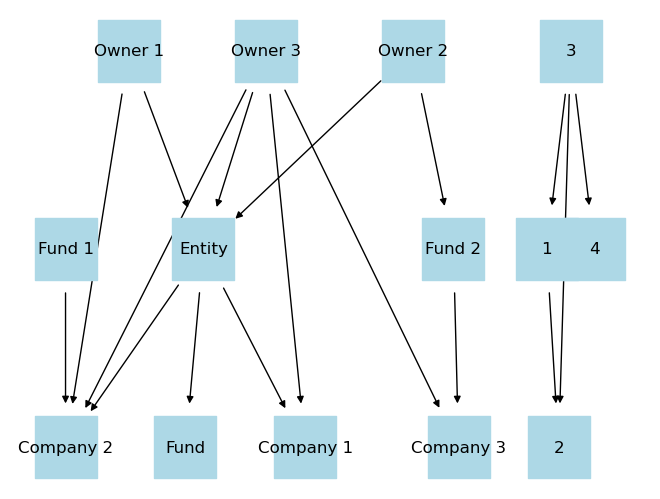

In [10]:
di_graph = graph.create_digraph()
graph.plot_digraph(di_graph)

In [11]:
from src.edge_validator import EdgeValidator

validator = EdgeValidator.from_json_file(str(from_root("datasets/test/json/4.json")), graph.edges)

In [12]:
validator.validate()

{'true_positives': ['owner 1-company 2',
  'owner 1-entity',
  'fund 1-company 2',
  'fund 2-company 3',
  'entity-company 1',
  'owner 3-company 3',
  'owner 3-entity'],
 'false_positives': ['entity-company 2',
  'owner 3-company 2',
  'owner 2-entity',
  'owner 2-fund 2',
  '1-2',
  'entity-fund',
  '3-1',
  '3-2',
  'owner 3-company 1',
  '3-4'],
 'false_negatives': [],
 'precision': 0.4117647058823529,
 'recall': 1.0,
 'f1_score': 0.5833333333333334}